# Procesamiento Digital de Señales <img src="./logo_UTN.svg" align="right" width="150"/>
## Alumno: Emanuel Olay
### Tarea Semanal: 10
Levanto todo como la TS9

In [154]:
# import warnings
# warnings.filterwarnings('ignore')


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import scipy.interpolate
import scipy.signal as sig
import scipy.io as sio
from scipy.fft import fft, fftshift
import matplotlib.patches as mpatches
from pandas import DataFrame
from IPython.display import HTML

width=15
height=5
plt.rcParams['figure.figsize'] = [width, height]

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

In [155]:
plt.close('all')

#sio.whosmat('ECG_TP4.mat')
mat_struct= sio.loadmat('ECG_TP4.mat')

fs= 1000 #Hz
figura=0

ecg= mat_struct['ecg_lead']

qrs_detections = mat_struct['qrs_detections']

patron_normal= mat_struct['heartbeat_pattern1']

patron_ventricular= mat_struct['heartbeat_pattern2']

N=len(ecg)

muestras_tot=np.arange(0,N,1)


##Delta muestras por debajo del pico
d_muestras1=200
##Delta muestras por arriba del pico
d_muestras2=300

ventana_temporal=np.arange(0,d_muestras1+d_muestras2,1)

In [156]:
#preparo el ecg para trabajar
latidos_matrix= [ (ecg[int(i-d_muestras1):int(i+d_muestras2)]) for i in qrs_detections ]
array_latidos=np.hstack(latidos_matrix)
#Los latidos estan a distintas alturas entonces sincronizo en y
#Tome la decision de restar la media de todo el experimento lo que en la mayoria
#de los casos deberia ser correcto
array_latidos=array_latidos - np.mean(array_latidos,axis=0)

In [157]:
#Busco separar los latidos ventriculares y los latidos normales en 2 grupos
maximos = array_latidos[200,:]
minimos = array_latidos[350,:]

#Es pico si supera
pico = 15000
#Es valle si cae por debajo
valle = -2000


indice_normales = np.bitwise_and(maximos < pico, minimos > valle)
##Todas las qrs detections que no cayeron en mi agrupacion anterior
indice_ventriculares = ~indice_normales


latidos_norm = array_latidos[:,indice_normales]
latidos_vent = array_latidos[:,indice_ventriculares]
normal_medio = np.mean(latidos_norm , axis=1)
ventricular_medio = np.mean(latidos_vent , axis=1)


# Plantilla del filtro
Banda detenida de $0$ a $0.1 Hz$ y de $45 Hz$ a $Nyquist$
Atenuacion:
<br>
$$\alpha_{min}=30dB$$
$$\alpha_{max}=0.1dB$$


In [158]:
#%%
#####Parametros para armar el filtro
nyq=fs/2
lowstop=0.1
lowcut = 1
highcut = 35
highstop=45
low_stop=lowstop/nyq
low_pass=lowcut/nyq
high_pass=highcut/nyq
high_stop=highstop/nyq
gpass = 0.1
gstop = 30

# Primer Filtro, butter

C:\Users\Ema\AppData\Local\Temp/ipykernel_8012/630909349.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h_butter)))


(0.0, 2500.0)

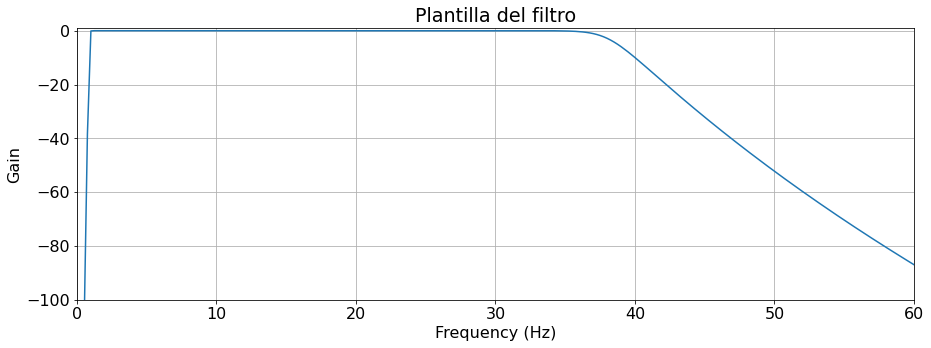

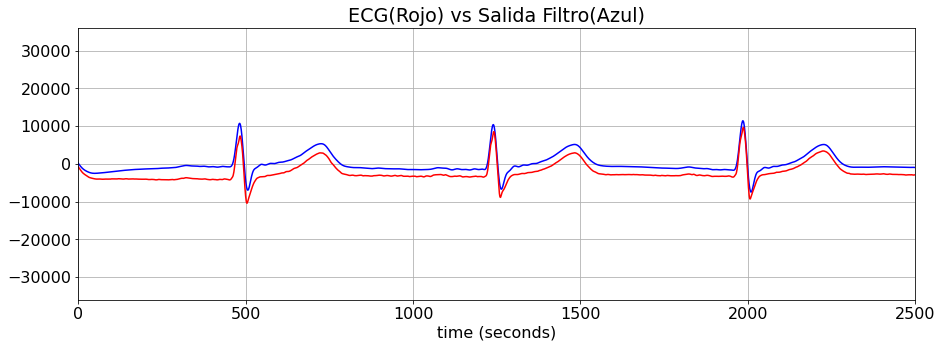

In [159]:
#####Armo el primer filtro IIR
system_butter=sig.iirdesign(wp=[low_pass,high_pass],
                     ws=[low_stop,high_stop],gpass=gpass,gstop=gstop,analog=False,
                     ftype='butter',output='sos')
##Muestro el filtro
plt.figure(figura)
figura+=1
w, h_butter = sig.sosfreqz(system_butter,fs=fs,worN=2000)
plt.plot(w, 20 * np.log10(abs(h_butter)))
plt.title('Plantilla del filtro')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.xlim(0,60)
plt.ylim(-100,1)
#####filtro la senal contra el ecg completo
y_butter= sig.sosfiltfilt(system_butter, ecg,axis=0,padtype='odd',padlen=None)
#Imprimo el resultado
plt.figure(figura)
figura+=1
plt.plot(y_butter,'b-')
plt.plot(ecg,'r-')
plt.title('ECG(Rojo) vs Salida Filtro(Azul)')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.xlim(0,2500)

Aqui vemos que el filtro en zonas de poco ruido no afecta practicamente a nuestra señal

(725000.0, 735000.0)

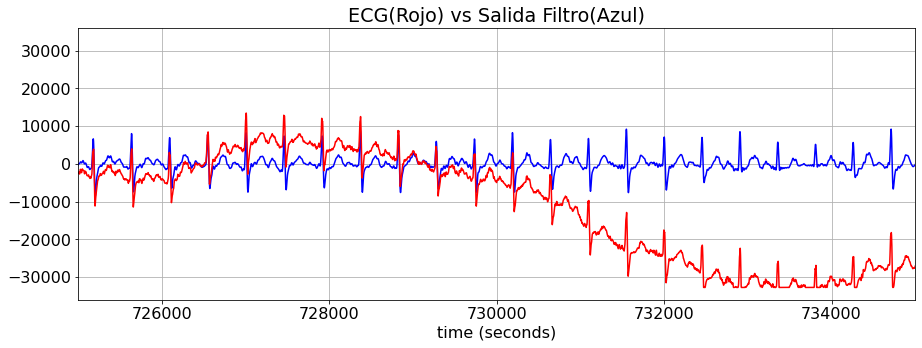

In [160]:
#Imprimo el resultado
plt.figure(figura)
figura+=1
plt.plot(y_butter,'b-')
plt.plot(ecg,'r-')
plt.title('ECG(Rojo) vs Salida Filtro(Azul)')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.xlim(725000,735000)

(726000.0, 728000.0)

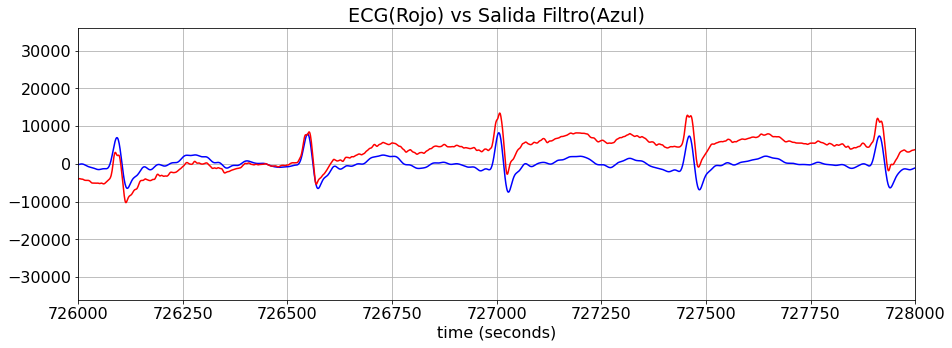

In [161]:
#Imprimo el resultado
plt.figure(figura)
figura+=1
plt.plot(y_butter,'b-')
plt.plot(ecg,'r-')
plt.title('ECG(Rojo) vs Salida Filtro(Azul)')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.xlim(726000,728000)

En zonas de mucho ruido hace un buen trabajo de quitar las interferencias. Tando de baja frecuencia como de alta frecuencia.

# Segundo Filtro, Cheby

C:\Users\Ema\AppData\Local\Temp/ipykernel_8012/33061550.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h_cheby)))


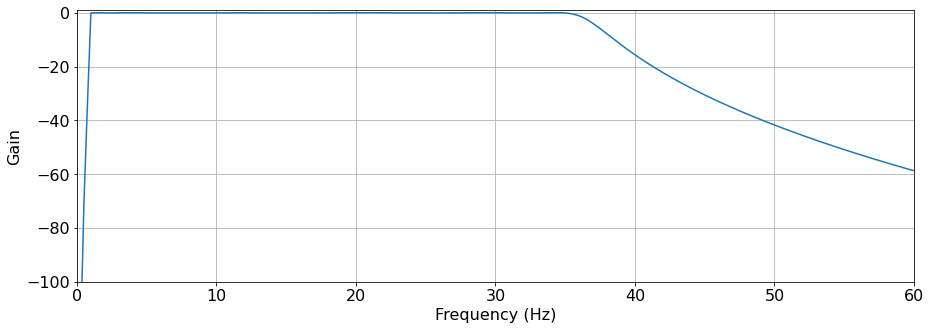

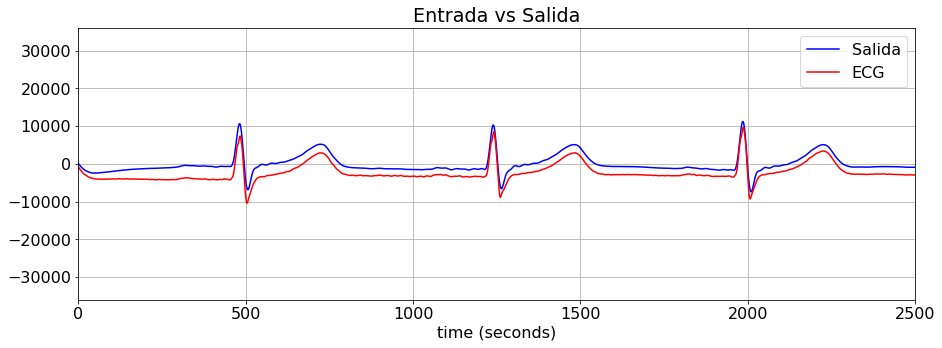

In [162]:
#%%Armo el segundo filtro IIR
system_cheby=sig.iirdesign(wp=[low_pass,high_pass],
                     ws=[low_stop,high_stop],gpass=gpass,gstop=gstop,analog=False,
                     ftype='cheby1',output='sos')
##Muestro el filtro
plt.figure(figura)
figura+=1
w, h_cheby = sig.sosfreqz(system_cheby,fs=fs,worN=2000)
plt.plot(w, 20 * np.log10(abs(h_cheby)))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.xlim(0,60)
plt.ylim(-100,1)

#####filtro la senal contra el ecg completo
y_cheby= sig.sosfiltfilt(system_cheby, ecg,axis=0,padtype='odd',padlen=None)
#Imprimo el resultado
plt.figure(figura)
figura+=1
plt.plot(y_cheby,'b-',label='Salida')
plt.plot(ecg,'r-',label='ECG')
plt.title('Entrada vs Salida')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.xlim(0,2500)
plt.legend()

Se puede apreciar que el filtro agrega un rizado que antes no estaba pero nada grave.

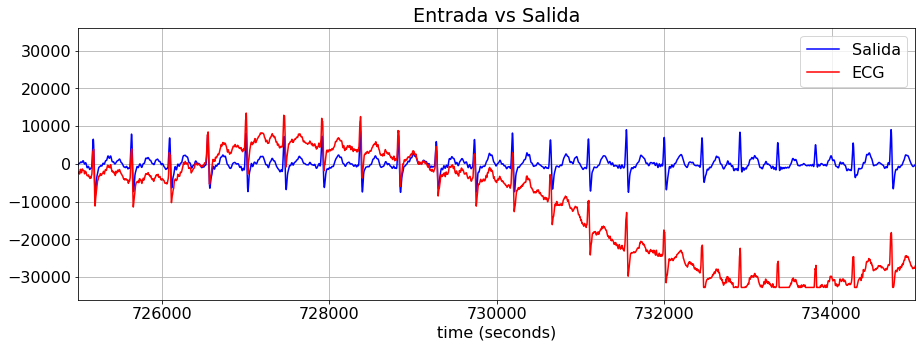

In [163]:
#Imprimo el resultado
plt.figure(figura)
figura+=1
plt.plot(y_cheby,'b-',label='Salida')
plt.plot(ecg,'r-',label='ECG')
plt.title('Entrada vs Salida')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.xlim(725000,735000)
plt.legend()

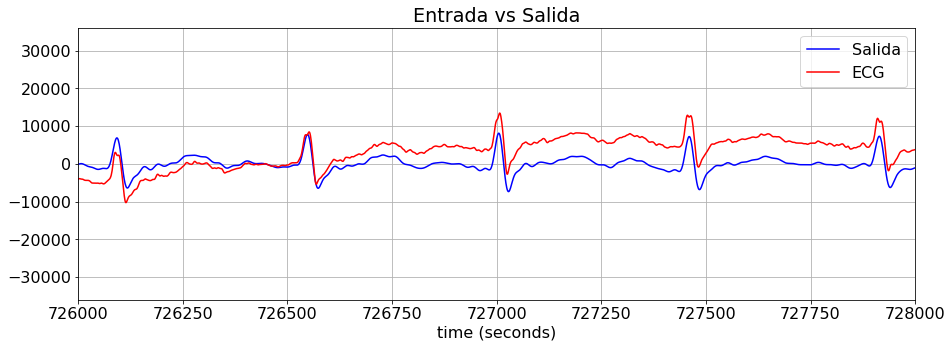

In [164]:
#Imprimo el resultado
plt.figure(figura)
figura+=1
plt.plot(y_cheby,'b-',label='Salida')
plt.plot(ecg,'r-',label='ECG')
plt.title('Entrada vs Salida')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.xlim(726000,728000)
plt.legend()

In [165]:
print("Orden butter:",system_butter.shape[0]*2)
print("Orden Cheby:",system_cheby.shape[0]*2)

Orden butter: 42
Orden Cheby: 16


Similar al otro filtro IIR cheby demuestra un buen rendimiento y varias de las deficiencias anteriores agravadas pero con menor orden.

# Tercer Filtro, FIRWIN

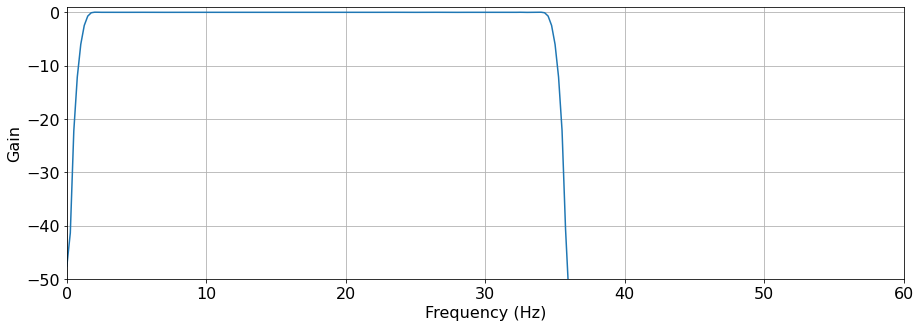

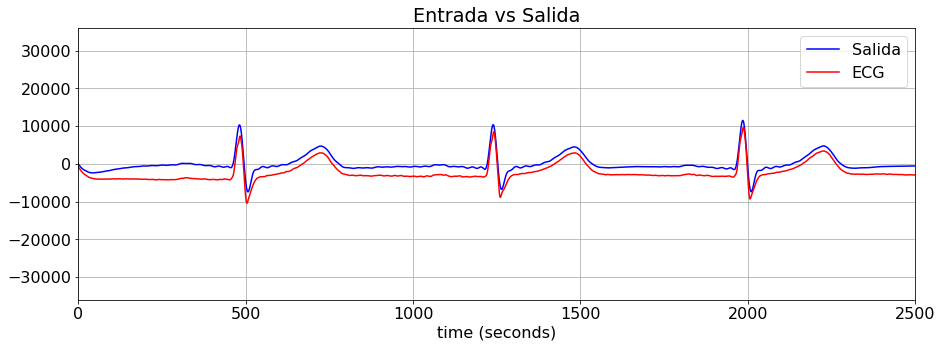

In [166]:
#%%Armo el primer filtro FIR

numtaps=2000##debe ser par para que el numtaps en al funcion sea impar

b_firwin=sig.firwin(numtaps=numtaps+1, cutoff=[lowcut, highcut], pass_zero=False,fs=fs)
##Muestro el filtro
plt.figure(figura)
figura+=1
w,h_firwin=sig.freqz(b=b_firwin, a=1, worN=2000, whole=False, plot=None, fs=fs, include_nyquist=False)
plt.plot(w, 20 * np.log10(abs(h_firwin)))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.xlim(0,60)
plt.ylim(-50,1)

#####filtro la senal contra el ecg completo
y_firwin = sig.filtfilt(b=b_firwin, a=1, x=ecg, axis=0, padtype='odd')
#Imprimo el resultado
plt.figure(figura)
figura+=1
plt.plot(y_firwin,'b-',label='Salida')
plt.plot(ecg,'r-',label='ECG')
plt.title('Entrada vs Salida')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.xlim(0,2500)
plt.legend()

Armar un remez pasa banda en una sola pasada se me hizo imposible asique implemente lo sugerido en calse 1 pasa bajos y 1 pasa altos

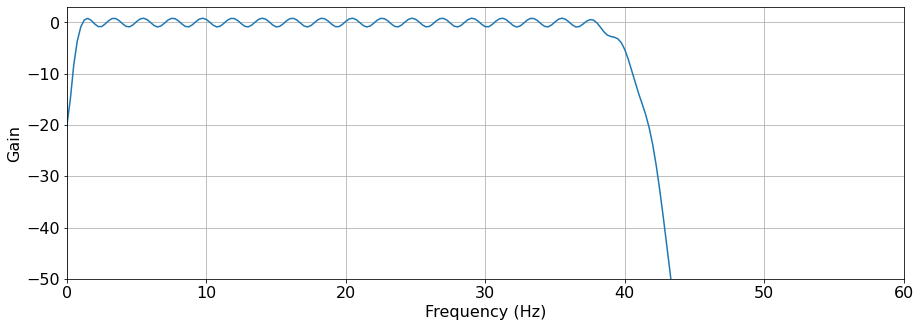

In [167]:
#%%Armo el segundo filtro FIR

lowstop=0.1
lowcut = 1
highcut = 35
highstop=45
# Pasa bajos
bands = np.array([0.0, highcut, highstop, nyq])
desired = [1,0]
numtaps = 930
remez_lp = sig.remez(numtaps+1, bands=bands, desired=desired, fs=fs)

# Pasa alto
bands = np.array([0.0, lowstop, lowcut, nyq])
desired = [0,1]
numtaps = 930
remez_hp = sig.remez(numtaps+1, bands=bands, desired=desired, fs=fs)

# Pasa banda
system_remez = np.polymul(remez_lp, remez_hp)
w,h_remez=sig.freqz(b=system_remez, a=1, worN=2000, whole=False, plot=None, fs=fs, include_nyquist=False)
plt.plot(w,20*np.log10(np.abs(h_remez)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.xlim(0,60)
plt.ylim(-50,3)

y_remez = sig.filtfilt(b=system_remez, a=1, x=ecg, axis=0, padtype='odd')

Paso a plotear todos juntos ahora que los tengo

C:\Users\Ema\AppData\Local\Temp/ipykernel_8012/2473486957.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h_butter)),label='Butter')
C:\Users\Ema\AppData\Local\Temp/ipykernel_8012/2473486957.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h_cheby)),label='Cheby')


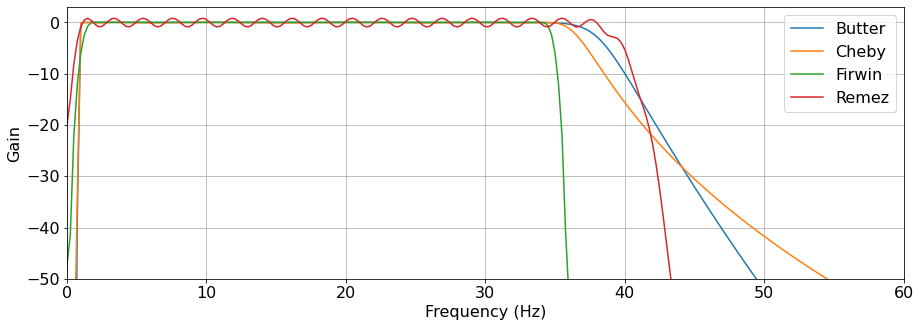

In [168]:
plt.plot(w, 20 * np.log10(abs(h_butter)),label='Butter')
plt.plot(w, 20 * np.log10(abs(h_cheby)),label='Cheby')
plt.plot(w, 20 * np.log10(abs(h_firwin)),label='Firwin')
plt.plot(w,20*np.log10(np.abs(h_remez)),label='Remez')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.xlim(0,60)
plt.ylim(-50,3)
plt.legend()

Por ultimo muestro todas las salidas y la entrada sobre una zona de interes

Text(0, 0.5, 'Amplitud')

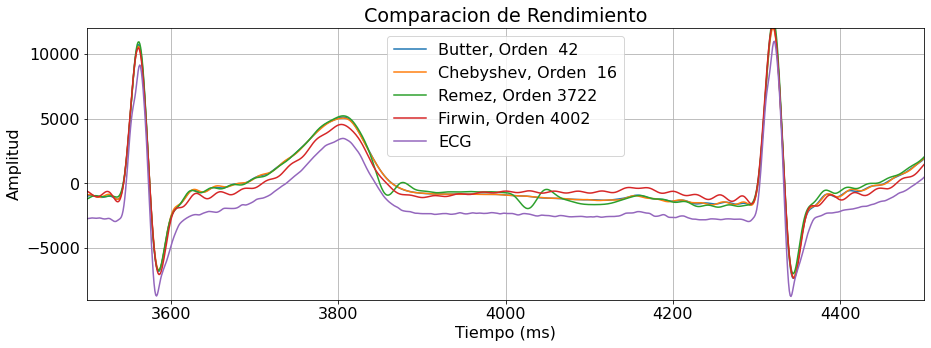

In [169]:
plt.plot(y_butter, label='Butter, Orden {:3.0f}'.format(system_butter.shape[0]*2))
plt.plot(y_cheby, label='Chebyshev, Orden {:3.0f}'.format(system_cheby.shape[0]*2))
plt.plot(y_remez, label='Remez, Orden {:3.0f}'.format(system_remez.shape[0]*2))
plt.plot(y_firwin, label='Firwin, Orden {:3.0f}'.format(b_firwin.shape[0]*2))
plt.plot(ecg, label='ECG')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend()
plt.xlim(3500,4500)
plt.ylim(-9000,12000)
plt.title('Comparacion de Rendimiento')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud')

Podemos apreciar que todos los filtros cumplen la plantilla propuesta satisfactoriamente aunque algunos se desempañan mejor que otros es evidente que las comparaciones no son justas ya que los filtros varian mucho del primero al cuarto.